# Проект №3: Exploratory Data Analysis and Feature Engineering #

**Подробное описание постановки задачи, ссылки на Kaggle (Competition + Notebook) приведены в файле [README.md](README.md)**

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from scipy import stats
import category_encoders as ce

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

DATA_PATH = 'data/'
# DATA_PATH = '/kaggle/input/sf-booking/'
OUTPUT_PATH = 'output/'
# OUTPUT_PATH = ''
RANDOM_STATE = 42

## Сбор и предварительный анализ данных (Data Collection) ##

In [2]:
train_df = pd.read_csv(DATA_PATH + 'hotels_train.csv')
test_df = pd.read_csv(DATA_PATH + 'hotels_test.csv')
submission_df = pd.read_csv(DATA_PATH + 'submission.csv')

In [3]:
display(train_df.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
display(test_df.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [5]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [6]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

In [7]:
display(submission_df.head(3))

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [8]:
display(submission_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

In [9]:
# Проверка на одновременное отстутствие 'lat' и 'lng' в одной строке
for df_ in train_df, test_df:
    print(df_.isna().sum(axis='columns').value_counts())

0    384355
2      2448
dtype: int64
0    128115
2       820
dtype: int64


Видно, что в обоих датасетах есть незаполненные координаты широты и долготы. Причём они отсутствуют одновременно, то есть нет строк с одной заполненной координатой, что немного упрощает дальнейшую работу.

Можно сразу преобразовать **`review_date`** в формат **`datetime`** и посмотреть, в какой период собирались данные.

In [10]:
for df_ in train_df, test_df:
    df_.review_date = pd.to_datetime(df_.review_date)

print(f'TRAIN_DF: данные с {train_df.review_date.min()} по {train_df.review_date.max()}')
print(f'TEST_DF: данные с {test_df.review_date.min()} по {test_df.review_date.max()}')

TRAIN_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00
TEST_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00


В обоих датасетах данные собраны с 4 августа 2015 по 3 августа 2017.

## Стратегия дальнейшей работы ##

Так как в данном проекте метод обучения модели фиксирован (RandomForestRegressor), и задан критерий качества модели&nbsp;&mdash; достижение минимального значения MAPE (Mean Absolute Percentage Error), то вместо последовательных этапов работы с данными (очистка, создание, преобразование, отбор) представляется более интересной следующая экспериментальная стратегия:

Первой итерацией будет простой отбор всех имеющихся числовых признаков и получение первого значения MAPE, от которого потом можно &laquo;плясать&raquo; далее по такому циклу:

1. Берём признак и смотрим, что можно сделать с числовым признаком (непрерывный/категориальный, распределение нормальное/нет, необходимость нормализации, стандартизации и других преобразований)
2. То же и со строковыми признаками (что можно вытянуть из строк сначала в числа или категории).
3. Отбор признаков (устранение излишней корреляции и мультиколлинеарности).
4. Обучение модели, отслеживание MAPE и анализ важности признаков.

Может быть получится излишне трудоёмко, но главная цель представляется как проработка процесса подготовки данных для готовой модели.

Кроме того, эксперименты показали, что для некоторых операций кодирования и нормализации удобно временно объединить обучающие и тестовые данные с дальнейшим их разделением перед обучением и тестированием модели. Поэтому в тестовый датасет добавляется заполненный нулями признак **`reviewer_score`** и в оба датасета&nbsp;&mdash; логический признак **`is_train`** для их последующего разделения:

In [11]:
test_df['reviewer_score'] = 0
train_df['is_train'] = True
test_df['is_train'] = False

# Слияние датасетов в один
full_df = pd.concat([train_df, test_df], axis='index', ignore_index=True)
display(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

None

### 1. **`hotel_address`**, **`lat`**, **`lng`**: Ккодирование признаков города из **`hotel_address`** и заполнение недостающих **`lat`** и **`lng`** некоторыми значениями ###

In [12]:
# Создание временного логического признака 'lost_hotel'
# (где координаты отсутствуют)
full_df['lost_hotel'] = full_df.lat.isna()

print(f'{full_df.hotel_address.nunique()} уникальных адресов отелей')
print(f'{full_df.lng.nunique()} уникальных долгот')
print(f'{full_df.lat.nunique()} уникальных широт')
print(f'{full_df[full_df.lost_hotel].hotel_address.nunique()} отелей без координат')

1493 уникальных адресов отелей
1472 уникальных долгот
1472 уникальных широт
17 отелей без координат


Итак, мы имеем дело с **1493** отелями. Для них есть **1472** уникальных координат и всего **17** отелей без координат (далее&nbsp;&mdash; &laquo;потерянные отели&raquo;, `lost_hotel` для удобства). Видимо, ещё у **4** оставшихся отелей координаты могут совпадать с какими-то другими.

Ещё можно посмотреть структуру содержимого **`hotel_address`**:

In [13]:
for str_ in full_df.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Структура ясна, можно посчитать число стран и городов, встречающихся во всех адресах:

In [14]:
countries = set()
cities = set()
for str_ in full_df.hotel_address:
    addr_ = str_.split()
    countries.add(addr_[-1])
    if addr_[-1] == 'Kingdom':
        cities.add(addr_[-5])
    else:
        cities.add(addr_[-2])
print(f'Всего {len(countries)} стран: {countries}')
print(f'Всего {len(cities)} городов: {cities}')

Всего 6 стран: {'Kingdom', 'France', 'Austria', 'Italy', 'Spain', 'Netherlands'}
Всего 6 городов: {'Paris', 'Amsterdam', 'Barcelona', 'Milan', 'Vienna', 'London'}


Выяснилось, что в датасетах содержатся отели только из шести городов однозначно соответствующих шести стран. Тогда можно сделать следующее:

Извлечь название город из **`hotel_address`** во временный признак **`city`**

In [15]:
def get_city(addr_str: str) -> str:
    ''' Находит в строке адреса название города
    Arguments:
        addr_str [str] -- Содержимое ячейки признака 'hotel_address'
    Returns:
        [str] -- Название города
    '''
    words_list = addr_str.split()
    if words_list[-1] == 'Kingdom':
        return words_list[-5]
    else:
        return words_list[-2]
    return 'Unknown'

# Создание временного признака 'city' для города
full_df['city'] = full_df.hotel_address.apply(get_city)

Интересно узнать количество потерянных отелей по городам:

In [16]:
# Выделение строк с потерянными отелями в отдельный датафрейм
lost_hotel_df = full_df[full_df.lost_hotel]

city_list = lost_hotel_df.city.unique()
for city_ in city_list:
    print(
        city_ + ':',
        lost_hotel_df[lost_hotel_df.city == city_].hotel_address.nunique(),
        'потерянных отелей'
    )

Vienna: 11 потерянных отелей
Paris: 3 потерянных отелей
Barcelona: 3 потерянных отелей


У нас не так уж много потерянных отелей. Можно даже заполнить их **`lat`** и **`lng`** вручную истинными координатами, определёнными по адресам, но можно поступить проще. Поскольку пара значений `(lat, lng)` представляют своего рода уникальный идентификатор, то достаточно каждому адресу отеля сопоставить такую уникальную числовую пару. Почти &laquo;от фонаря&raquo;. Например, чтобы не сильно портить статисткику распределения, для 17 отелей назначить пары из значений в пределах соответствующих IQR (от Q25 до Q75) для каждого из трёх городов.

In [17]:
# Составление словаря адресов потерянных отелей (key)
# с новыми координатами (value)
lost_hotel_coords_dict = {}
for city_ in ['Vienna', 'Paris', 'Barcelona']:
    # Выборки для конкретного города
    df = full_df[full_df.city == city_]
    lost_hotel_per_city_df = lost_hotel_df[lost_hotel_df.city == city_]
    # Список адресов потерянных отелей в городе
    lost_hotel_addr_list = list(lost_hotel_per_city_df.hotel_address.unique())
    lost_hotel_count = len(lost_hotel_addr_list)
    # Определение границ IQR для 'lat' и 'lng'
    lat_q25 = df.lat.quantile(0.25)
    lat_q75 = df.lat.quantile(0.75)
    lng_q25 = df.lng.quantile(0.25)
    lng_q75 = df.lng.quantile(0.75)
    # Формирование наборов значений для 'lat' и 'lng'
    lat_tuple = tuple(np.linspace(lat_q25, lat_q75, lost_hotel_count))
    lng_tuple = tuple(np.linspace(lng_q25, lng_q75, lost_hotel_count))
    # Формирование словаря
    coords_dict = dict(zip(lost_hotel_addr_list, zip(lat_tuple, lng_tuple)))
    lost_hotel_coords_dict.update(coords_dict)

# Составление списков индексов строк с потерянными отелями
lost_hotel_index_list = list(lost_hotel_df.index)

# Заполнение отсутствующих координат
for i_ in lost_hotel_index_list:
    new_coords = lost_hotel_coords_dict.get(full_df.hotel_address.iloc[i_])
    full_df.lat.iloc[i_] = new_coords[0]
    full_df.lng.iloc[i_] = new_coords[1]

# display(full_df.info())

<ipython-input-17-cc106aa246ca>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.lat.iloc[i_] = new_coords[0]
<ipython-input-17-cc106aa246ca>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.lng.iloc[i_] = new_coords[1]


***Альтернативный вариант (при экспериментах чаще показывал худшие результаты и сейчас выключен, хотя может пригодиться на новых этапах)***

Заполняем пустые ячейки в признаках **`lat`** и **`lng`** координатами центров соответствующих городов (взяты из внешних источников)

In [1191]:
"""
full_df.lat.fillna(0, inplace=True)
full_df.lng.fillna(0, inplace=True)

# Координаты центров городов (lat, lng) из внешних источников
CITY_COORDS = {
    'Amsterdam': (52.383333, 4.9),
    'Barcelona': (41.383333, 2.183333),
    'London': (51.507222, -0.1275),
    'Milan': (45.466667, 9.166667),
    'Paris': (48.833333, 2.333333),
    'Vienna': (48.216667, 16.373333)
}

def write_lat(city_: str, lat_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение широты в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        lat_ [float] -- Широта
    Returns:
        [float] -- Широта (lattitude)
    '''
    if lat_ == 0:
        return CITY_COORDS[city_][0]
    return lat_


def write_lng(city_: str, lng_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение долготы в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        kng_ [float] -- Долгота
    Returns:
        [float] -- Обновлённая долгота (longitude)
    '''
    if lng_ == 0:
        return CITY_COORDS[city_][1]
    return lng_


# Заполнение недостающих значений в признаках 'lat' и 'lng'
full_df.lat = full_df[['city', 'lat']].apply(
                                            lambda x:
                                            write_lat(x.city, x.lat),
                                            axis='columns'
                                            )
full_df.lng = full_df[['city', 'lng']].apply(
                                             lambda x:
                                             write_lng(x.city, x.lng),
                                             axis='columns'
                                            )
"""

"\nfull_df.lat.fillna(0, inplace=True)\nfull_df.lng.fillna(0, inplace=True)\n\n# Координаты центров городов (lat, lng) из внешних источников\nCITY_COORDS = {\n    'Amsterdam': (52.383333, 4.9),\n    'Barcelona': (41.383333, 2.183333),\n    'London': (51.507222, -0.1275),\n    'Milan': (45.466667, 9.166667),\n    'Paris': (48.833333, 2.333333),\n    'Vienna': (48.216667, 16.373333)\n}\n\ndef write_lat(city_: str, lat_: float) -> float:\n    ''' Выдаёт для строки датафрейма недостающее значение широты в\n    зависимости от признака 'city'. Существующее значение оставляет без\n    изменений.\n    Arguments:\n        city_ [str] -- Город\n        lat_ [float] -- Широта\n    Returns:\n        [float] -- Широта (lattitude)\n    '''\n    if lat_ == 0:\n        return CITY_COORDS[city_][0]\n    return lat_\n\n\ndef write_lng(city_: str, lng_: float) -> float:\n    ''' Выдаёт для строки датафрейма недостающее значение долготы в\n    зависимости от признака 'city'. Существующее значение оставляе

Можно было бы закодировать признак **`city`**, но он коррелирует с координатами, поэтому избавляемся от признаков **`city`** и **`lost_hotel`**:

In [18]:
full_df.drop(columns=['city', 'lost_hotel'], inplace=True)

### 2. **`review_date`**: Создание признака **`DOY`** (Day Of Year) ###

Сама по себе дата ничего полезного не несёт, к тому же, преобразованный в интервал, коррелирует с **`days_since_review`**. Но может быть полезен день года (посещаемость и отзывы в зависимости от сезона).

In [19]:
full_df['DOY'] = full_df.review_date.dt.dayofyear

### 3. **`days_since_review`**: Преобразование в числовой формат ###

In [20]:
full_df.days_since_review = \
    full_df.days_since_review.apply(lambda x: int(x.split()[0]))

### 4. **`tags`**: Создание числового признака **`stayed_nights`** и кодирование некоторых дополнительных признаков ###

In [21]:
split_tag_str = lambda x: x.lstrip("[\' ").rstrip(" \']").split(" \', \' ")

def get_stayed_nights(tags_str: str) -> int:
    ''' Разбивает строку признака 'tags' на отдельные тэги. Затем ищет
    тэг 'Stayed * nights' и возвращает число ночёвок. Если тэг не
    найден, возвращает 0.
    Arguments:
        tags_str [str] -- Содержимое ячейки признака 'tags'
    Returns:
        [int] -- Число проведённых в отеле ночей
    '''
    tag_list = split_tag_str(tags_str)
    for tag_ in tag_list:
        words_list = tag_.split()
        if words_list[0] == 'Stayed':
            return int(words_list[1])
    return 0

full_df['stayed_nights'] = full_df.tags.apply(get_stayed_nights)

Можно посмотреть на Top-25 наиболее часто встречающихся тэгов:

In [22]:
# Создание словаря-счётчика тэгов
tag_count_dict = {}
for tag_str in full_df.tags:
    tag_list = split_tag_str(tag_str)
    for tag_ in tag_list:
        if tag_ in tag_count_dict:
            tag_count_dict[tag_] += 1
        else:
            tag_count_dict[tag_] = 1

# Лист ключей словаря, отсортированный по убыванию счётчика тэгов
sorted_tag_list = sorted(tag_count_dict,
                         key=lambda x: tag_count_dict[x], reverse=True)

for item in sorted_tag_list[:25]:
    print(f'{item} == {tag_count_dict[item]}')

Leisure trip == 417778
Submitted from a mobile device == 307640
Couple == 252294
Stayed 1 night == 193645
Stayed 2 nights == 133937
Solo traveler == 108545
Stayed 3 nights == 95821
Business trip == 82939
Group == 65392
Family with young children == 61015
Stayed 4 nights == 47817
Double Room == 35207
Standard Double Room == 32248
Superior Double Room == 31393
Family with older children == 26349
Deluxe Double Room == 24823
Double or Twin Room == 22393
Stayed 5 nights == 20845
Standard Double or Twin Room == 17483
Classic Double Room == 16989
Superior Double or Twin Room == 13570
2 rooms == 12393
Stayed 6 nights == 9776
Standard Twin Room == 9745
Single Room == 9670


Для создания новых (бинарных) признаков могут быть интересны тэги **`Leisure trip`**, **`Business trip`**, **`Solo traveler`**, **`Couple`**, **`Group`**.

In [23]:
full_df['leisure'] = full_df.tags.apply(lambda x: 1 if 'Leisure trip' in x else 0)
full_df['business'] = full_df.tags.apply(lambda x: 1 if 'Business trip' in x else 0)
full_df['solo'] = full_df.tags.apply(lambda x: 1 if 'Solo traveler' in x else 0)
full_df['couple'] = full_df.tags.apply(lambda x: 1 if 'Couple' in x else 0)
full_df['group'] = full_df.tags.apply(lambda x: 1 if 'Group' in x else 0)

***Далее идут попытки размышлений, что можно сделать с имеющимися числовыми признакакми. Пока немного.***

### 5. **`additional_number_of_scoring`**: ###

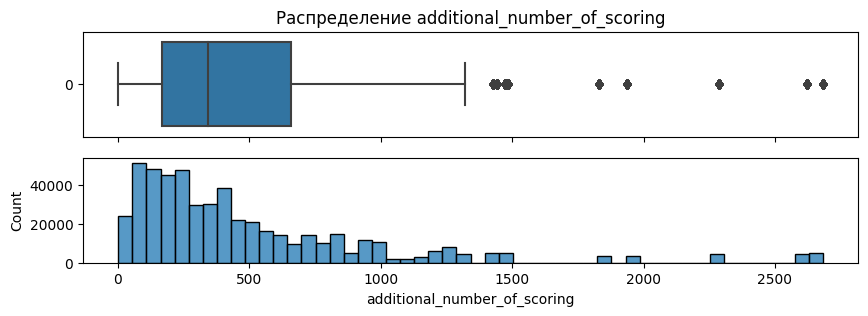

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.additional_number_of_scoring,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.additional_number_of_scoring,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение additional_number_of_scoring');

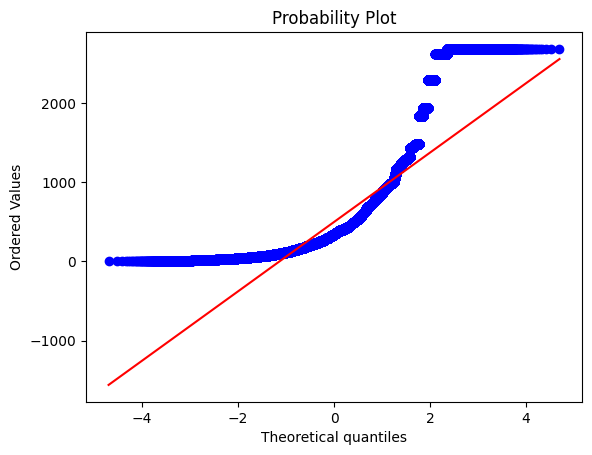

In [25]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.additional_number_of_scoring, plot=plt)
plt.show();

### 6. **`average_score`**: Стандартизация (preprocessing.StandardScaler) ###

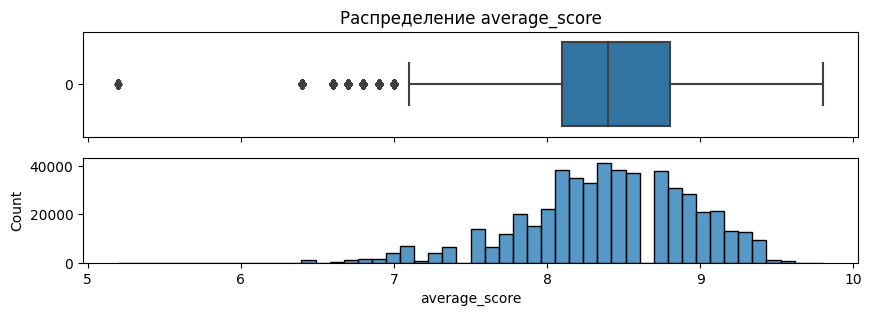

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.average_score,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.average_score,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение average_score');

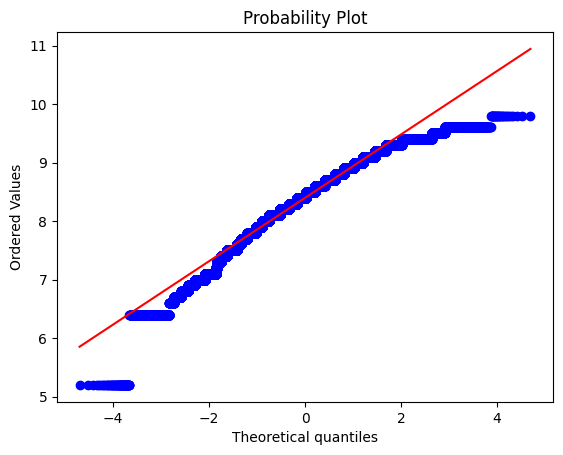

In [27]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.average_score, plot=plt)
plt.show();

Только признак average_score показывает более-менее нормальное распределение, поэтому его можно стандартизировать.

In [28]:
s_scaler = preprocessing.StandardScaler()
scaled_df = s_scaler.fit_transform(full_df[['average_score']])
scaled_df = pd.DataFrame(scaled_df, columns=['average_score'])
full_df.update(scaled_df)

### 7. **`total_number_of_reviews`**: ###

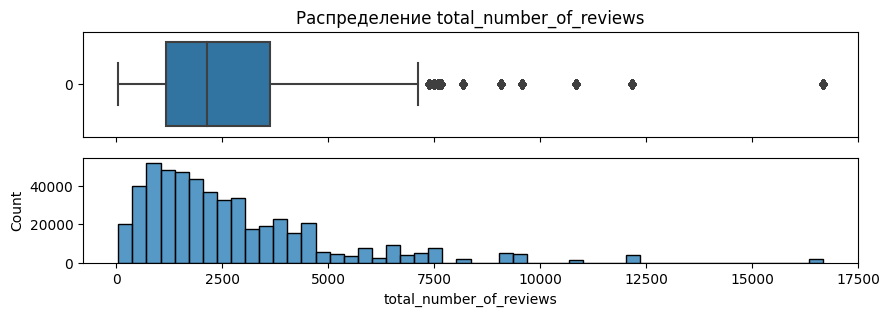

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.total_number_of_reviews,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.total_number_of_reviews,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение total_number_of_reviews');

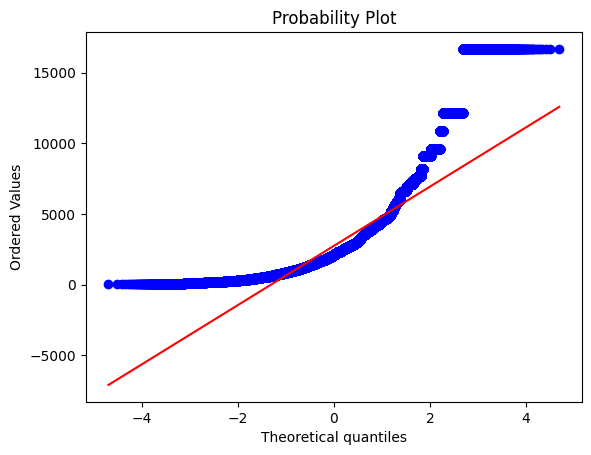

In [30]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.total_number_of_reviews, plot=plt)
plt.show();

### 8. **`total_number_of_reviews_reviewer_has_given`**: ###

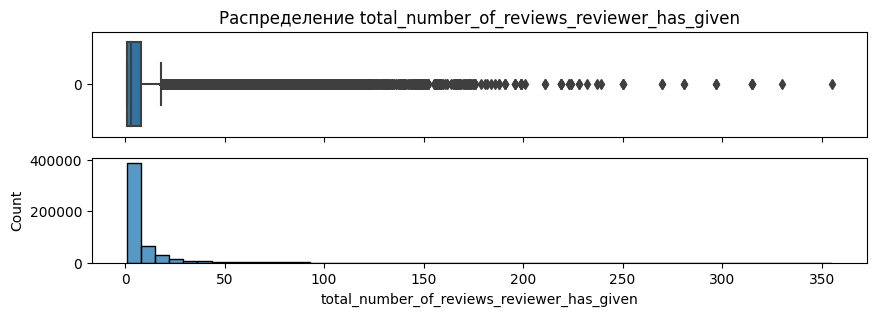

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.total_number_of_reviews_reviewer_has_given,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.total_number_of_reviews_reviewer_has_given,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение total_number_of_reviews_reviewer_has_given');

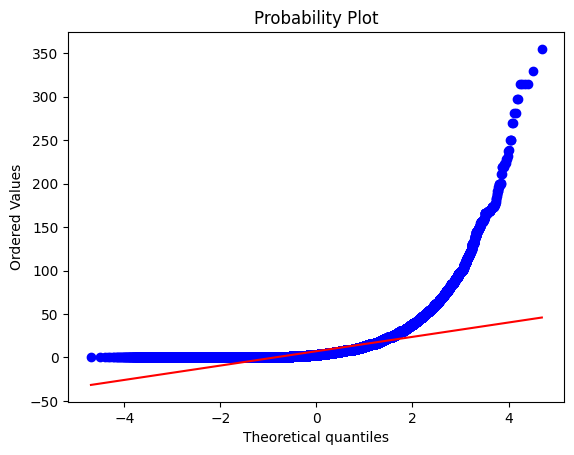

In [32]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.total_number_of_reviews_reviewer_has_given, plot=plt)
plt.show();

### 9. **`review_total_positive_word_counts`**: Подлежит нормализации ###

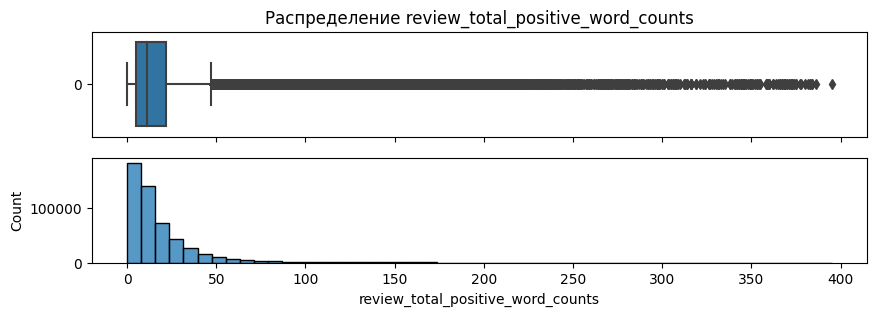

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.review_total_positive_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.review_total_positive_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение review_total_positive_word_counts');

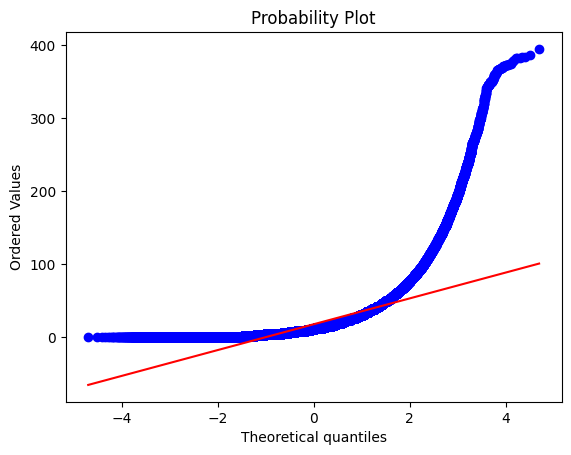

In [34]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.review_total_positive_word_counts, plot=plt)
plt.show();

### 10. **`review_total_negative_word_counts`**: Подлежит нормализации ###

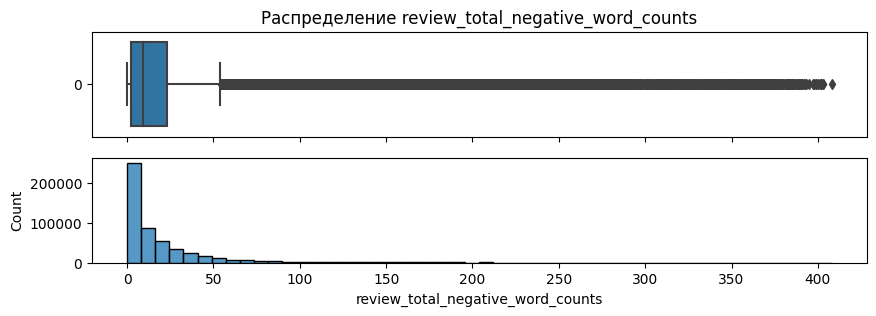

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=full_df.review_total_negative_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=full_df.review_total_negative_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение review_total_negative_word_counts');

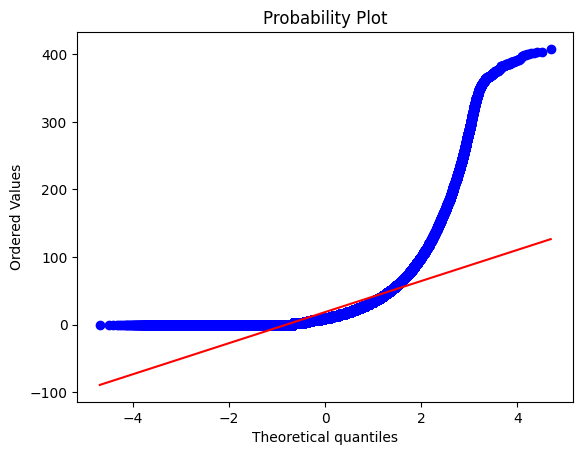

In [36]:
plt.subplot(1, 1, 1)
stats.probplot(full_df.review_total_negative_word_counts, plot=plt)
plt.show();

### Нормализация выбранных признаков (preprocessing.RobustScaler) ###

Эксперименты показали, что результат заметно улучшает нормализация только признаков **`review_total_positive_word_counts`** и **`review_total_negative_word_counts`**.

In [37]:
col_list = [
    'review_total_positive_word_counts',
    'review_total_negative_word_counts'
]
r_scaler = preprocessing.RobustScaler()

scaled_df = r_scaler.fit_transform(full_df[col_list])
scaled_df = pd.DataFrame(scaled_df, columns=col_list)
full_df.update(scaled_df)


### 11. **`reviewer_nationality`**: Бинарное кодирование (category_encoders.BinaryEncoder) ###

In [38]:
print(f'{full_df.reviewer_nationality.nunique()} уникальных значений в признаке reviewer_nationality')

227 уникальных значений в признаке reviewer_nationality


В признаке **`reviewer_nationality`** 227 стран. Можно с помощью бинарного кодирования создать до 8 новых признаков, и эксериментально посмотреть, сколько даёт максимальный эффект (оказалось, кодирование 62 наиболее часто встречающихся стран плюс &laquo;другие&raquo;, дающие 6 новых признаков, показало максимальный эффект).

In [39]:
country_list = \
    list(full_df.reviewer_nationality.value_counts().nlargest(62).index)
full_df.reviewer_nationality = \
    full_df.reviewer_nationality.apply(lambda x: x if x in country_list else ' Other ')

n_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
n_enc_df = n_encoder.fit_transform(full_df.reviewer_nationality)
full_df = pd.concat([full_df, n_enc_df], join='outer', axis='columns')

### 12. **`hotel_name`** ###

In [40]:
print(f'{full_df.hotel_name.nunique()} уникальных значений в признаке hotel_name')

1492 уникальных значений в признаке hotel_name


Здесь проводим бинарное кодирование всех имён отелей, что даёт в результате 11 новых признаков:

In [41]:
h_encoder = ce.BinaryEncoder(cols=['hotel_name'])
h_enc_df = h_encoder.fit_transform(full_df.hotel_name)
full_df = pd.concat([full_df, h_enc_df], join='outer', axis='columns')

## Отбор признаков ##

In [42]:
# "Распиливаем" обратно полные данные на обучающий и тестовый датасеты
train_df = full_df[full_df.is_train]
test_df = full_df[full_df.is_train == False]

# Удаление 'is_train' и целевого признака из тестового датасета
train_df.drop(columns='is_train', inplace=True)
test_df.drop(columns=['is_train', 'reviewer_score'], inplace=True)

<ipython-input-42-cee18b67529e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns='is_train', inplace=True)
<ipython-input-42-cee18b67529e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['is_train', 'reviewer_score'], inplace=True)


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  float64       
 8   total_number_of_reviews                     386803 non-null  int64        

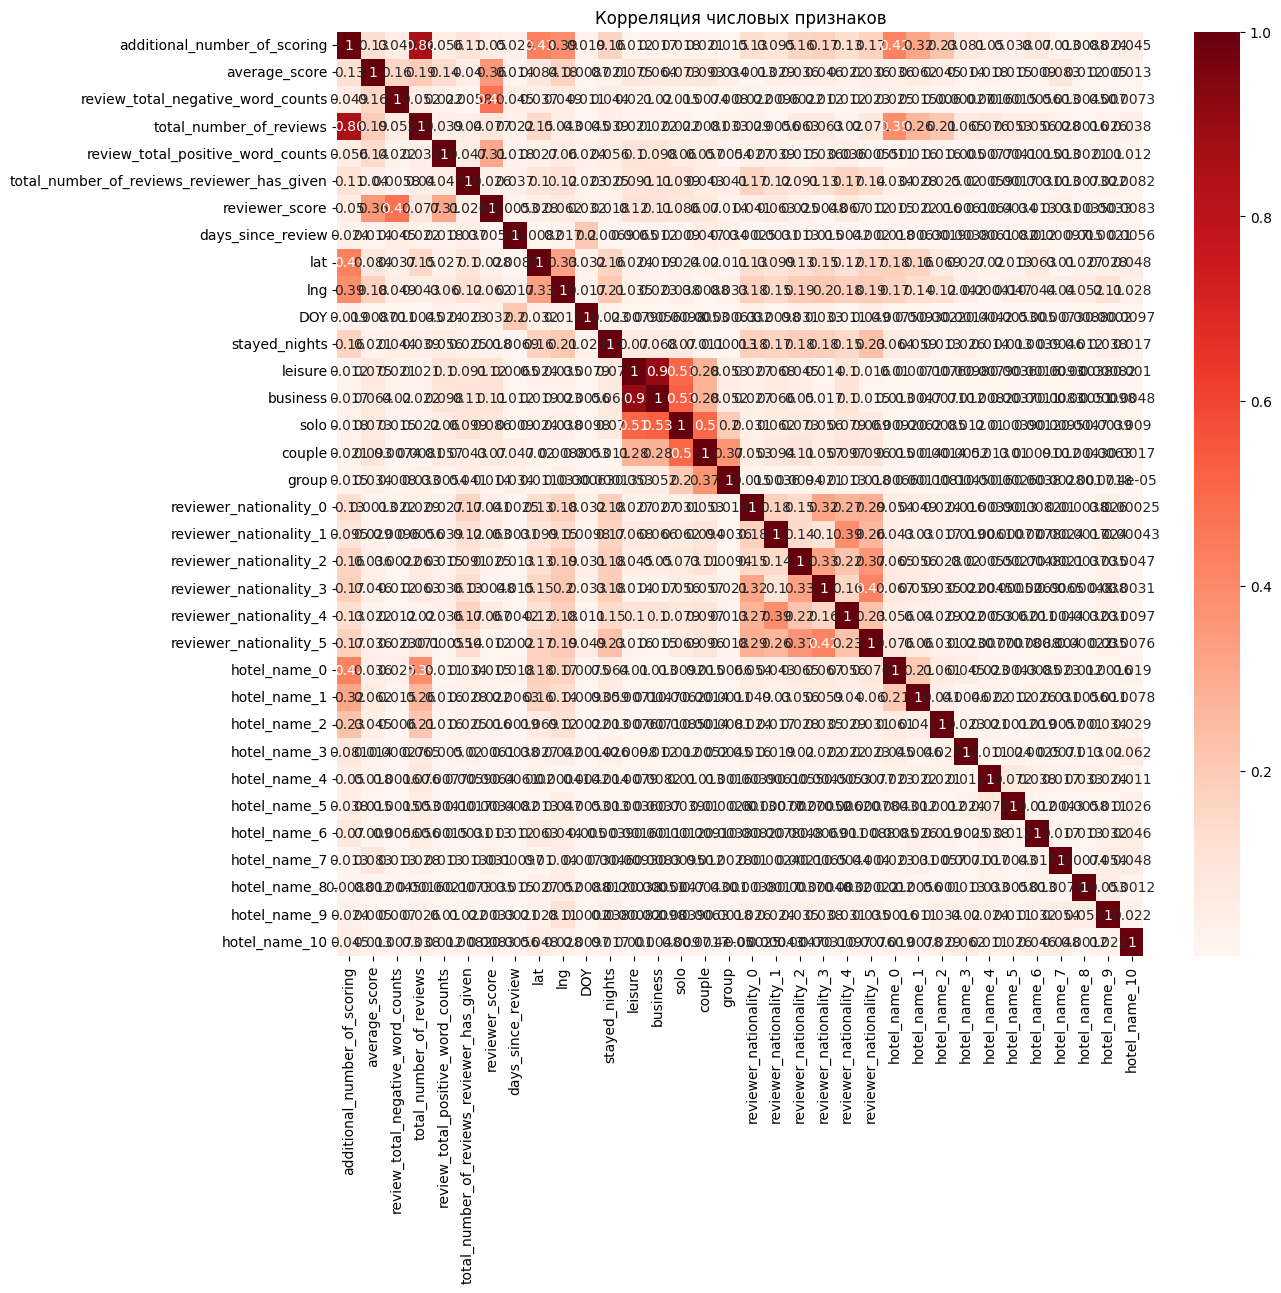

In [44]:
plt.figure(figsize=(13, 12))
heatmap = sns.heatmap(data=train_df.corr(method='spearman').abs(), annot=True, cmap='Reds')
heatmap.set_title('Корреляция числовых признаков')
plt.show()

Помимо нечисловых признаков убираем **`additional_number_of_scoring`** из-за сильной корреляции с **`total_number_of_reviews`**. А также **`business`** сильно коррелирует с **`leisure`**.

In [45]:
drop_features_list = [
    'hotel_address',
    'additional_number_of_scoring',
    'review_date',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    'positive_review',
    'tags',
    'business'
]
for df_ in train_df, test_df:
    df_.drop(columns=drop_features_list, inplace=True)

<ipython-input-45-176dc506b5c6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop(columns=drop_features_list, inplace=True)
<ipython-input-45-176dc506b5c6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop(columns=drop_features_list, inplace=True)


## Обучение модели ##

In [46]:
X = train_df.drop(columns=['reviewer_score'])
y = train_df.reviewer_score
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE
                                                   )

In [47]:
regressor = RandomForestRegressor(
                                  n_estimators=100,
                                  n_jobs=4,
                                  random_state=RANDOM_STATE
                                 )
regressor.fit(X_train, y_train)
y_predictor = regressor.predict(X_test)

## Оценка качества модели ##

In [48]:
print(f'MAPE:', metrics.mean_absolute_percentage_error(y_test, y_predictor))

MAPE: 0.1358322722554003


## Оценка значимости признаков ##

In [49]:
display(pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False))

review_total_negative_word_counts             0.274311
review_total_positive_word_counts             0.154632
average_score                                 0.087104
days_since_review                             0.072961
DOY                                           0.072660
total_number_of_reviews                       0.048243
lat                                           0.046427
lng                                           0.045796
total_number_of_reviews_reviewer_has_given    0.040622
stayed_nights                                 0.026560
couple                                        0.008142
leisure                                       0.007943
reviewer_nationality_2                        0.006902
reviewer_nationality_3                        0.006879
reviewer_nationality_5                        0.006803
solo                                          0.006656
reviewer_nationality_1                        0.006561
reviewer_nationality_0                        0.006403
reviewer_n

## Формирование предсказаний ##

In [50]:
predictions = regressor.predict(test_df)
submission_df.reviewer_score = predictions
submission_df.head()

,reviewer_score,id
0,8.996,488440
1,7.017,274649
2,8.285,374688
3,9.356,404352
4,9.680,451596


In [51]:
submission_df.shape

(128935, 2)

In [52]:
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)